In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import IFrame
import webbrowser

**Generating a pandas dataframe from the source .csv file**

In [33]:
# Set options to show all columns
pd.set_option('display.max_columns', None)

# Load csv file and generate pandas dataframe
input_csv = r'..\data\clean\after_step_3b_outliers_cat.csv' # Fill your path to file
df_1 = pd.read_csv(input_csv, sep = ',')

df_1.head()

,id,locality_name,Postal_code,Price,Subtype,Number_of_bedrooms,Living_area,street,number,latitude,longitude,Open_fire,Swimming_Pool,hasTerrace,terraceSurface,gardenSurface,Kitchen_type,Number_of_facades,State_of_building,Furnished,epc,landSurface,price_per_sqm,price_per_sqm_land,Province,Assigned_City,Has_Assigned_City,Kitchen_type_encoded,State_of_building_encoded,EPC_encoded
0,20252354,Ronse,9600,319000,House,3,125,Rotterij,148,50.744176,3.625722,0,0,1,0,370,Installed,4,To renovate,0,F,767.0,2552.000000,415.906128,East Flanders,NaN,True,1,0,0
1,20251003,Geraardsbergen,9500,299999,House,3,167,Pirrestraat,17,50.752121,3.925495,0,0,1,0,895,Installed,2,Good,0,D,1050.0,1796.401198,285.713333,East Flanders,NaN,True,1,2,2
2,20252002,Mechelen,2800,275000,House,3,154,Caputsteenstraat,150,51.033269,4.491795,0,0,1,10,20,Semi equipped,2,To renovate,0,E,120.0,1785.714286,2291.666667,Antwerp,NaN,True,2,0,1
3,20252352,Gooik,1755,295000,House,3,172,Strijlandstraat,45,50.791877,4.084293,0,0,1,0,300,Installed,3,To renovate,0,F,309.0,1715.116279,954.692557,Brabant_Wallon,NaN,True,1,0,0
4,20251715,Dilbeek,1700,715000,House,3,280,Herdebeekstraat 94-94A,0,50.840610,4.228425,0,1,1,36,374,Installed,3,As new,0,C,374.0,2553.571429,1911.764706,Brabant_Wallon,NaN,True,1,4,3


**Approach**

*Numerical data:*
1. Scatter plots

2. Determine if two numerical datasets have a linear correlation, via Pearson coefficient:
- 0.0 to 0.3: Weak
- 0.3 to 0.7: Moderate
- 0.7 to 1.0: Strong
--> generate matrix and heat map for visualization

3. If non-linear: Spearman’s Correlation for non-linear correlation of data (non-parametric measure of monotonic relationships) --> values from -1 to 1:
- 0.0 to 0.3 (or 0.0 to -0.3): Weak correlation
- 0.3 to 0.7 (or -0.3 to -0.7): Moderate correlation
- 0.7 to 1.0 (or -0.7 to -1.0): Strong correlation
--> generate matrix and heat map for visualization

*Categorical data:*
1. Scatter plots
2. Spearman’s Correlation for non-linear correlation of data (non-parametric measure of monotonic relationships)
--> generate matrix and heat map for visualization

*Boolean data:*
1. Scatter plots
2. Determine linear relationships between a binary and numerical dataset, via Point-Biserial Correlation:
- 0.0 to 0.3 (or 0.0 to -0.3): Weak correlation
- 0.3 to 0.7 (or -0.3 to -0.7): Moderate correlation
- 0.7 to 1.0 (or -0.7 to -1.0): Strong correlation
--> generate matrix and heat map for visualization

3. If non-linear, but you suspect monotonic relationship: Spearman’s Rank Correlation
--> generate matrix and heat map for visualization

*When to Use Spearman’s Rank Correlation:*
-Non-linear relationships: When you suspect the relationship between variables is monotonic but not linear.
-Ordinal data: When your data is not continuous or normally distributed (e.g., ranks, ordered categories).
-Robust to outliers: Spearman’s correlation is less sensitive to outliers because it uses rank values rather than actual data values.

**Adjusting the data types**
Possible problem with moving between notebooks

In [34]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5021 non-null   int64  
 1   locality_name              5021 non-null   object 
 2   Postal_code                5021 non-null   int64  
 3   Price                      5021 non-null   int64  
 4   Subtype                    5021 non-null   object 
 5   Number_of_bedrooms         5021 non-null   int64  
 6   Living_area                5021 non-null   int64  
 7   street                     5021 non-null   object 
 8   number                     5005 non-null   object 
 9   latitude                   5021 non-null   float64
 10  longitude                  5021 non-null   float64
 11  Open_fire                  5021 non-null   int64  
 12  Swimming_Pool              5021 non-null   int64  
 13  hasTerrace                 5021 non-null   int64

In [35]:
# transform 'int64' to 'Int64' to handle NaN

int_columns = df_1.select_dtypes(include=['int64'])

for col in int_columns.columns:
    df_1[col] = df_1[col].astype('Int64')
    
# transform dtypes 'object' to 'category'
obj_columns = df_1.select_dtypes(include=['object'])

for col in obj_columns.columns:
    df_1[col] = df_1[col].astype('category')

df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         5021 non-null   Int64   
 1   locality_name              5021 non-null   category
 2   Postal_code                5021 non-null   Int64   
 3   Price                      5021 non-null   Int64   
 4   Subtype                    5021 non-null   category
 5   Number_of_bedrooms         5021 non-null   Int64   
 6   Living_area                5021 non-null   Int64   
 7   street                     5021 non-null   category
 8   number                     5005 non-null   category
 9   latitude                   5021 non-null   float64 
 10  longitude                  5021 non-null   float64 
 11  Open_fire                  5021 non-null   Int64   
 12  Swimming_Pool              5021 non-null   Int64   
 13  hasTerrace                 5021 n

In [36]:
df_1['Postal_code'] = df_1['Postal_code'].astype('category')

df_1['Open_fire'] = df_1['Open_fire'].astype('bool')
df_1['Swimming_Pool'] = df_1['Swimming_Pool'].astype('bool')
df_1['hasTerrace'] = df_1['hasTerrace'].astype('bool')
df_1['Furnished'] = df_1['Furnished'].astype('bool')

df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         5021 non-null   Int64   
 1   locality_name              5021 non-null   category
 2   Postal_code                5021 non-null   category
 3   Price                      5021 non-null   Int64   
 4   Subtype                    5021 non-null   category
 5   Number_of_bedrooms         5021 non-null   Int64   
 6   Living_area                5021 non-null   Int64   
 7   street                     5021 non-null   category
 8   number                     5005 non-null   category
 9   latitude                   5021 non-null   float64 
 10  longitude                  5021 non-null   float64 
 11  Open_fire                  5021 non-null   bool    
 12  Swimming_Pool              5021 non-null   bool    
 13  hasTerrace                 5021 n

In [37]:
# Overview and grouping of the datacolumns for loop later on
numerical_columns = ['Price','price_per_sqm','price_per_sqm_land','Living_area','gardenSurface', 'terraceSurface','Number_of_facades','Number_of_bedrooms']
categorical_columns = ['Subtype','Kitchen_type','State_of_building','epc','Postal_code','Province', 'Assigned_City']
binary_columns = ['Swimming_Pool','hasTerrace','Open_fire','Furnished', 'Has_Assigned_City']

**All numerical data - display pairplots and check linearity via Pearson .corr() method**

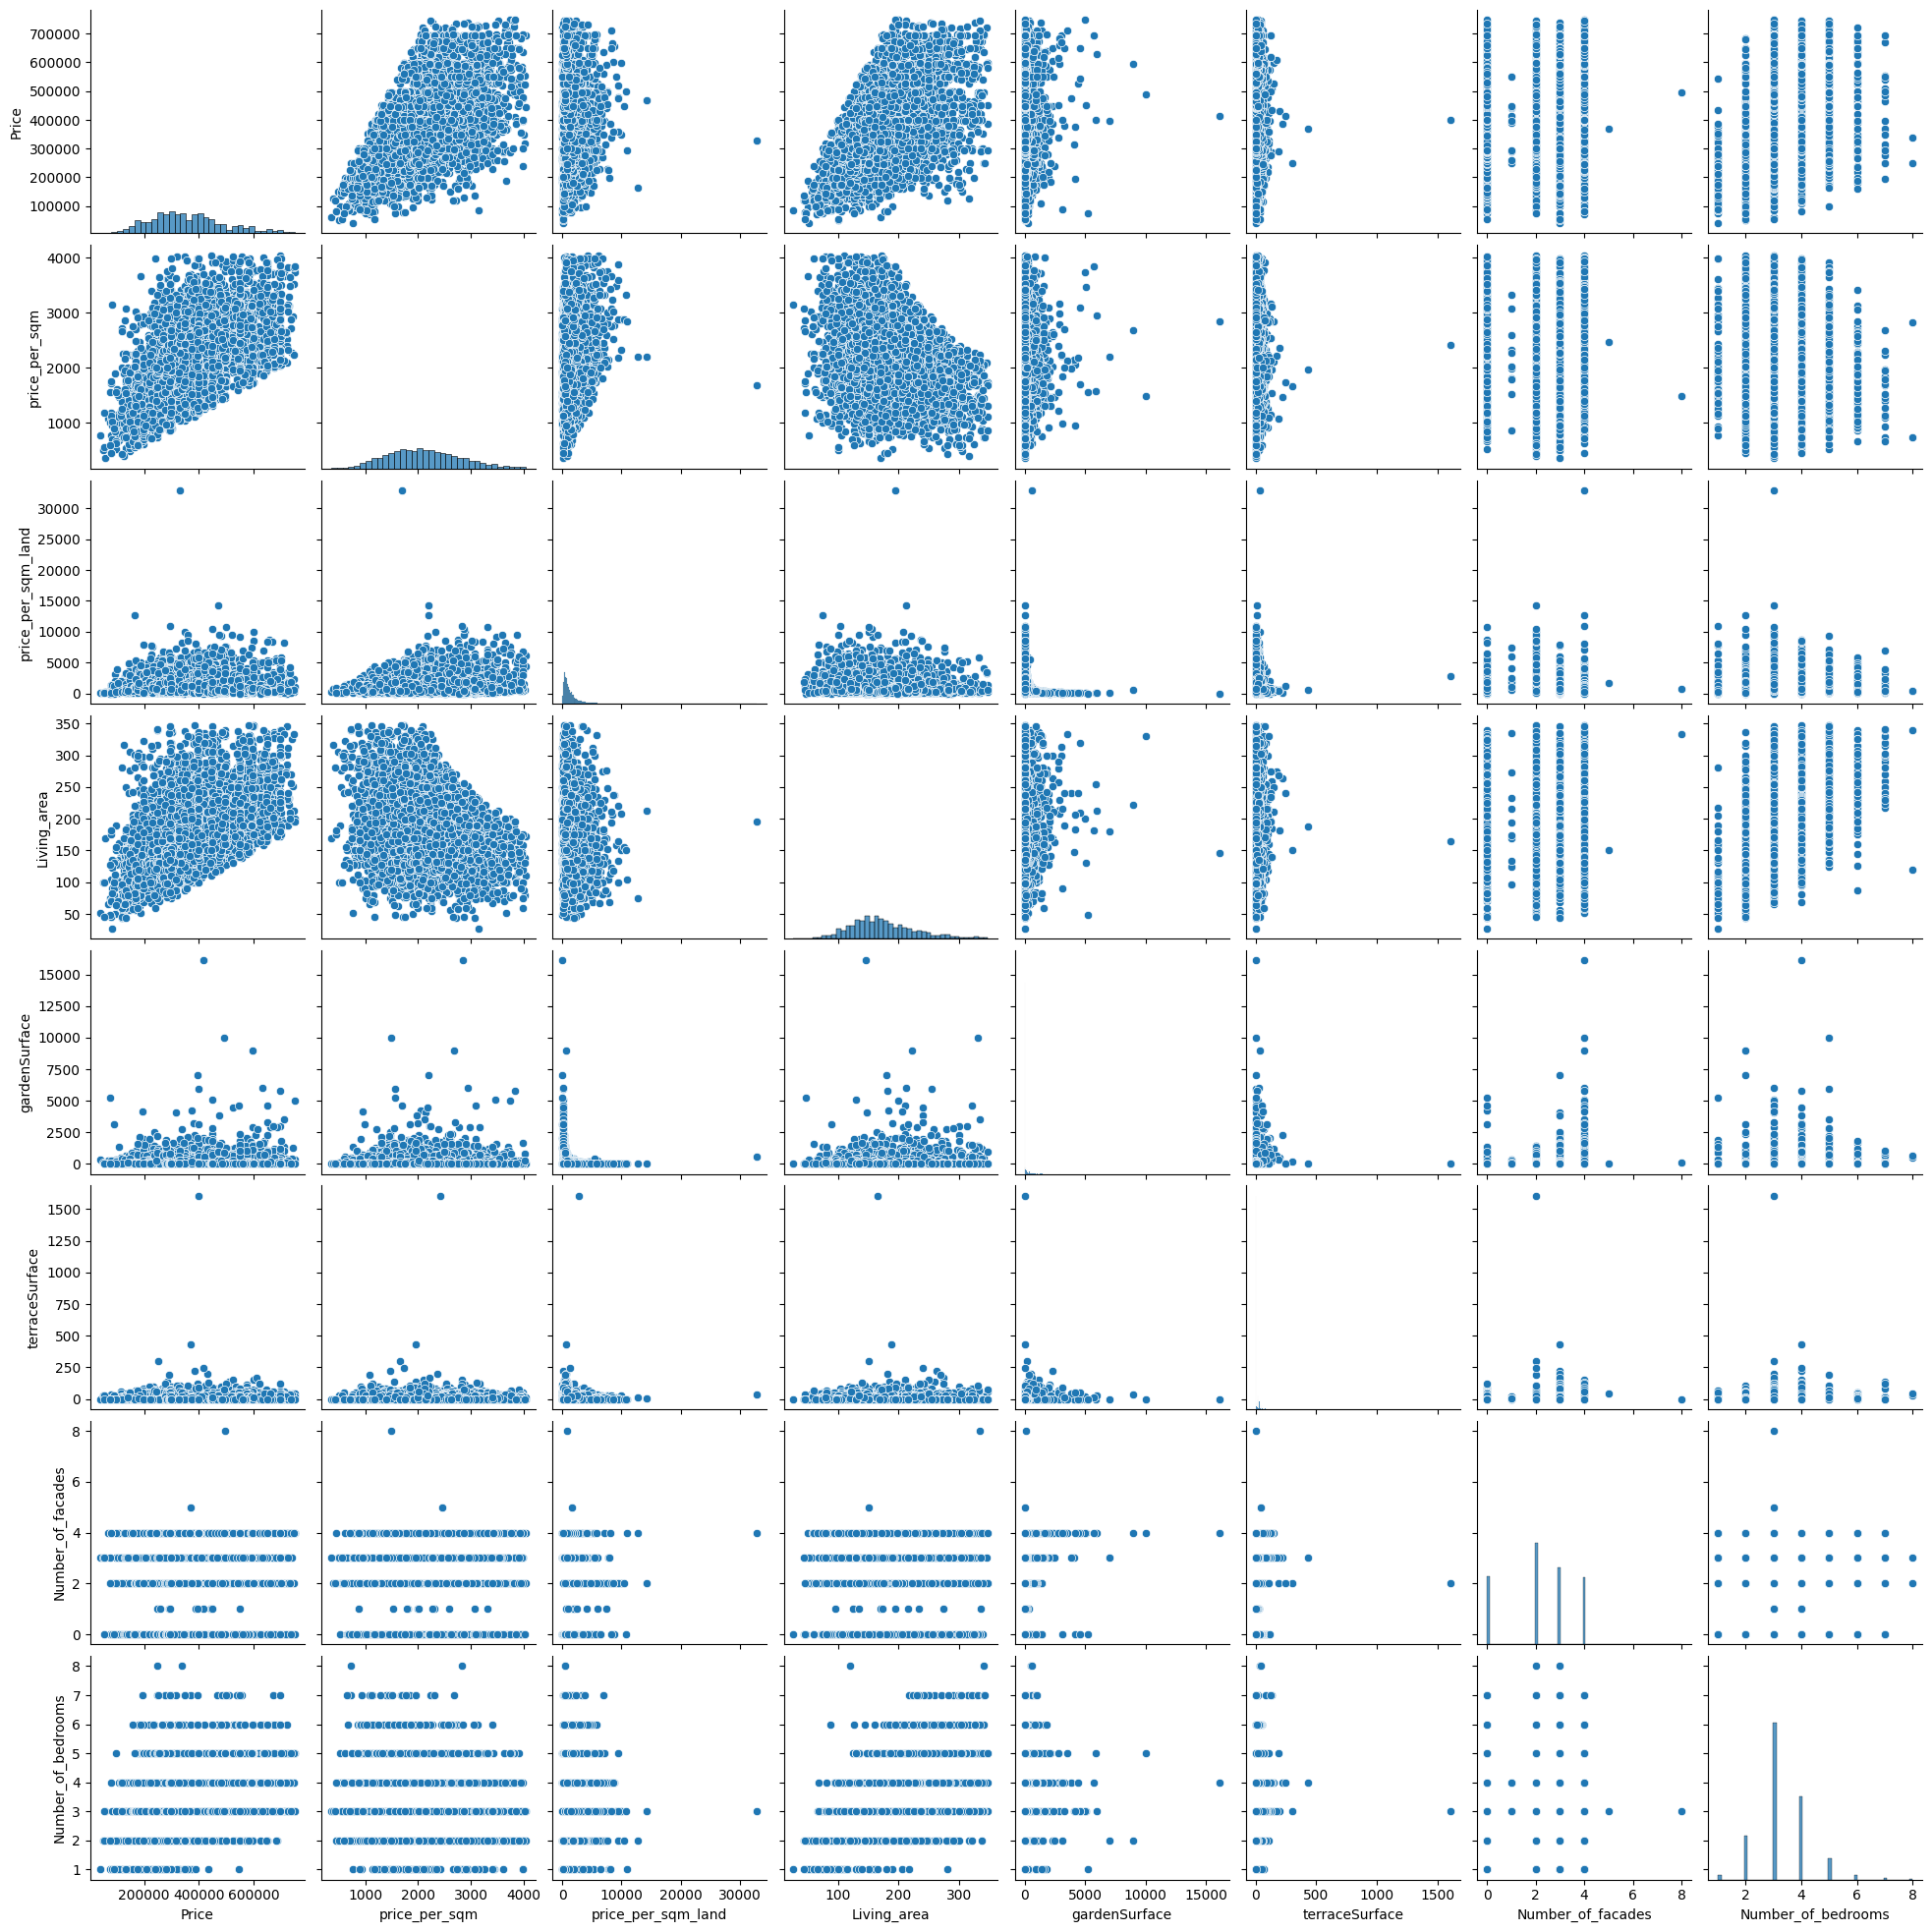

Pearson correlation coefficients:
                       Price  price_per_sqm  price_per_sqm_land  Living_area  \
Price               1.000000       0.621168            0.104772     0.535161   
price_per_sqm       0.621168       1.000000            0.259085    -0.279638   
price_per_sqm_land  0.104772       0.259085            1.000000    -0.122378   
Living_area         0.535161      -0.279638           -0.122378     1.000000   
gardenSurface       0.107278       0.031598           -0.186757     0.087224   
terraceSurface      0.061826       0.020187           -0.017527     0.051736   
Number_of_facades   0.122005       0.061492           -0.181487     0.068824   
Number_of_bedrooms  0.325052      -0.099773           -0.004028     0.520726   

                    gardenSurface  terraceSurface  Number_of_facades  \
Price                    0.107278        0.061826           0.122005   
price_per_sqm            0.031598        0.020187           0.061492   
price_per_sqm_land      -0.18

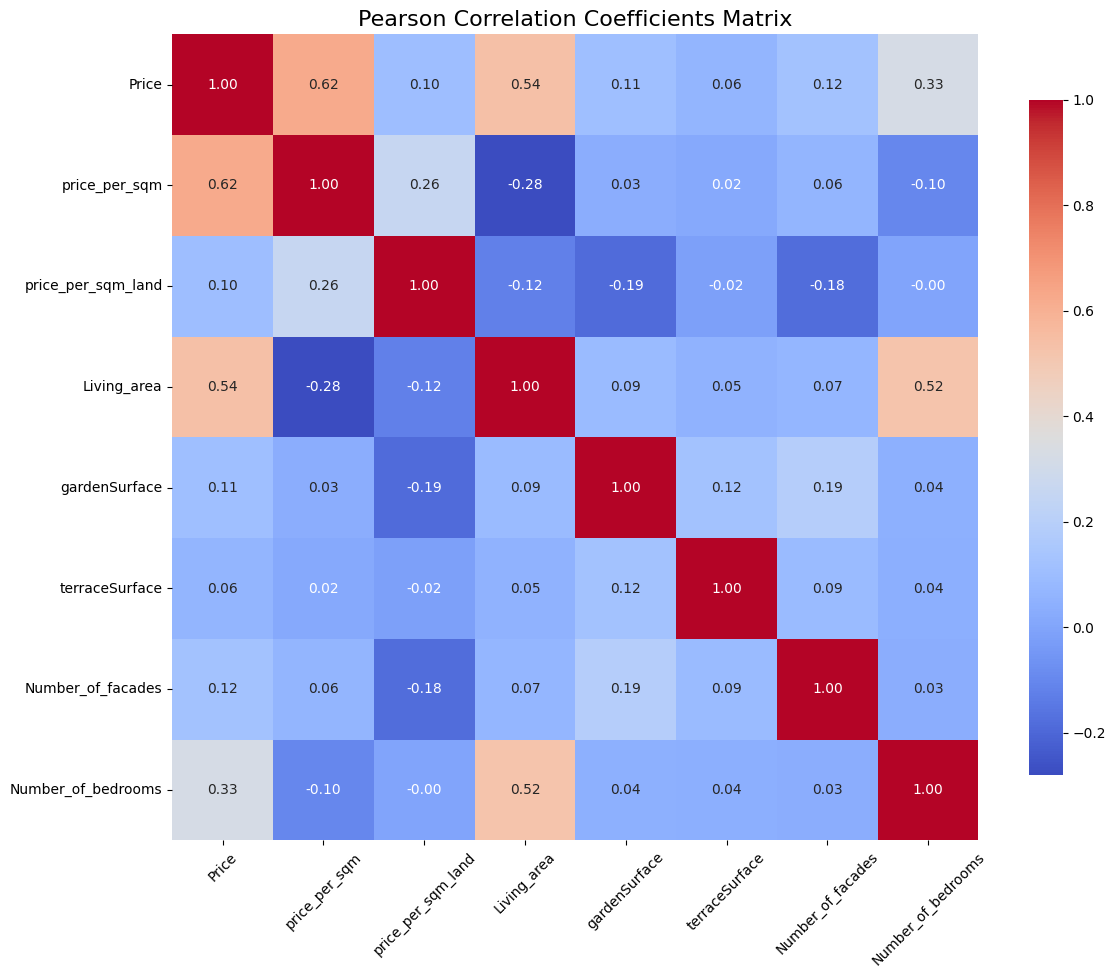

In [38]:
# Select numerical variables
#numerical_columns = df_1.select_dtypes(include=['Int64', 'float64']).columns.tolist()

# Step 1: Visualize the relationship using scatter plots
sns.pairplot(df_1[numerical_columns])
plt.show()

# Step 2: Calculate Pearson correlation coefficient only for numerical variables
pearson_correlation = df_1[numerical_columns].corr(method='pearson')

# Display the Pearson correlation coefficients table
print("Pearson correlation coefficients:")
print(pearson_correlation)

# Set up the plot
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_correlation, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title
plt.title('Pearson Correlation Coefficients Matrix', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=0)   # Y-axis labels horizontal
plt.tight_layout()       # Automatically adjust layout
plt.show()

**Display pairplots and check linearity via of boolean versus numerical via Point-Biserial .corr() method**


c:\Users\tom_v\becode_projects\3_ImmoWeb_scraper\immo-eliza-team6-analysis\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5657: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
c:\Users\tom_v\becode_projects\3_ImmoWeb_scraper\immo-eliza-team6-analysis\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5657: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
c:\Users\tom_v\becode_projects\3_ImmoWeb_scraper\immo-eliza-team6-analysis\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5657: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
c:\Users\tom_v\becode_projects\3_ImmoWeb_scraper\immo-eliza-team6-analysis\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5657: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pea

                      Price price_per_sqm price_per_sqm_land Living_area  \
Swimming_Pool      0.122499      0.054443                NaN    0.080032   
hasTerrace         0.116366      0.087234                NaN    0.056156   
Open_fire          0.097393      0.013995                NaN     0.10657   
Furnished            0.0001      0.046062                NaN   -0.037199   
Has_Assigned_City       NaN           NaN                NaN         NaN   

                  gardenSurface terraceSurface Number_of_facades  \
Swimming_Pool          0.056627       0.058731          0.067756   
hasTerrace             0.055084       0.218476          0.100146   
Open_fire              0.095021       0.051105          0.097813   
Furnished             -0.003671       0.022459         -0.020395   
Has_Assigned_City           NaN            NaN               NaN   

                  Number_of_bedrooms  
Swimming_Pool               0.046304  
hasTerrace                  0.034431  
Open_fire        

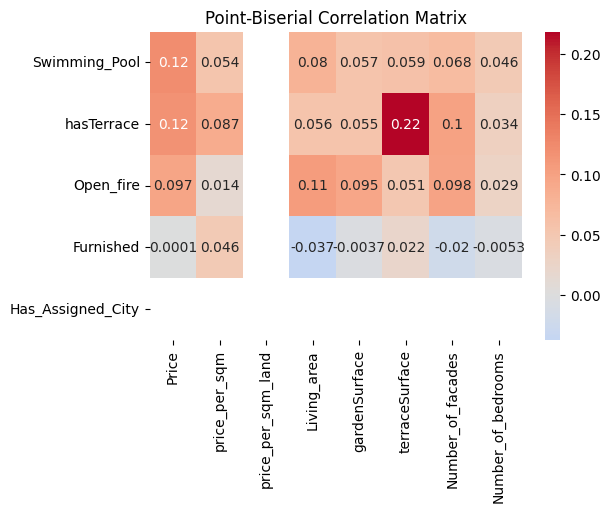

In [39]:
# Convert boolean columns to 0/1 for calculation
df_1[binary_columns] = df_1[binary_columns].astype(int)

# Create an empty DataFrame to store the point-biserial correlations
correlation_matrix = pd.DataFrame(index=binary_columns, columns=numerical_columns)

# Calculate point-biserial correlation for each binary vs numerical pair
for binary_col in binary_columns:
    for numerical_col in numerical_columns:
        corr, _ = pointbiserialr(df_1[binary_col], df_1[numerical_col])
        correlation_matrix.loc[binary_col, numerical_col] = corr

# Display the correlation matrix
print(correlation_matrix)

# Convert the correlation matrix to numeric values for visualization
correlation_matrix = correlation_matrix.astype(float)

# Plot a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title("Point-Biserial Correlation Matrix")
plt.show()

**Checking correlation of encoded categorical (= ordinal data) to numerical data, as well as correlations that were non-linear in Pearson and point-biserial tests, via Spearman method**

In [40]:
#here code from Izabela

old code from Rik --> keep for now, remove at the end

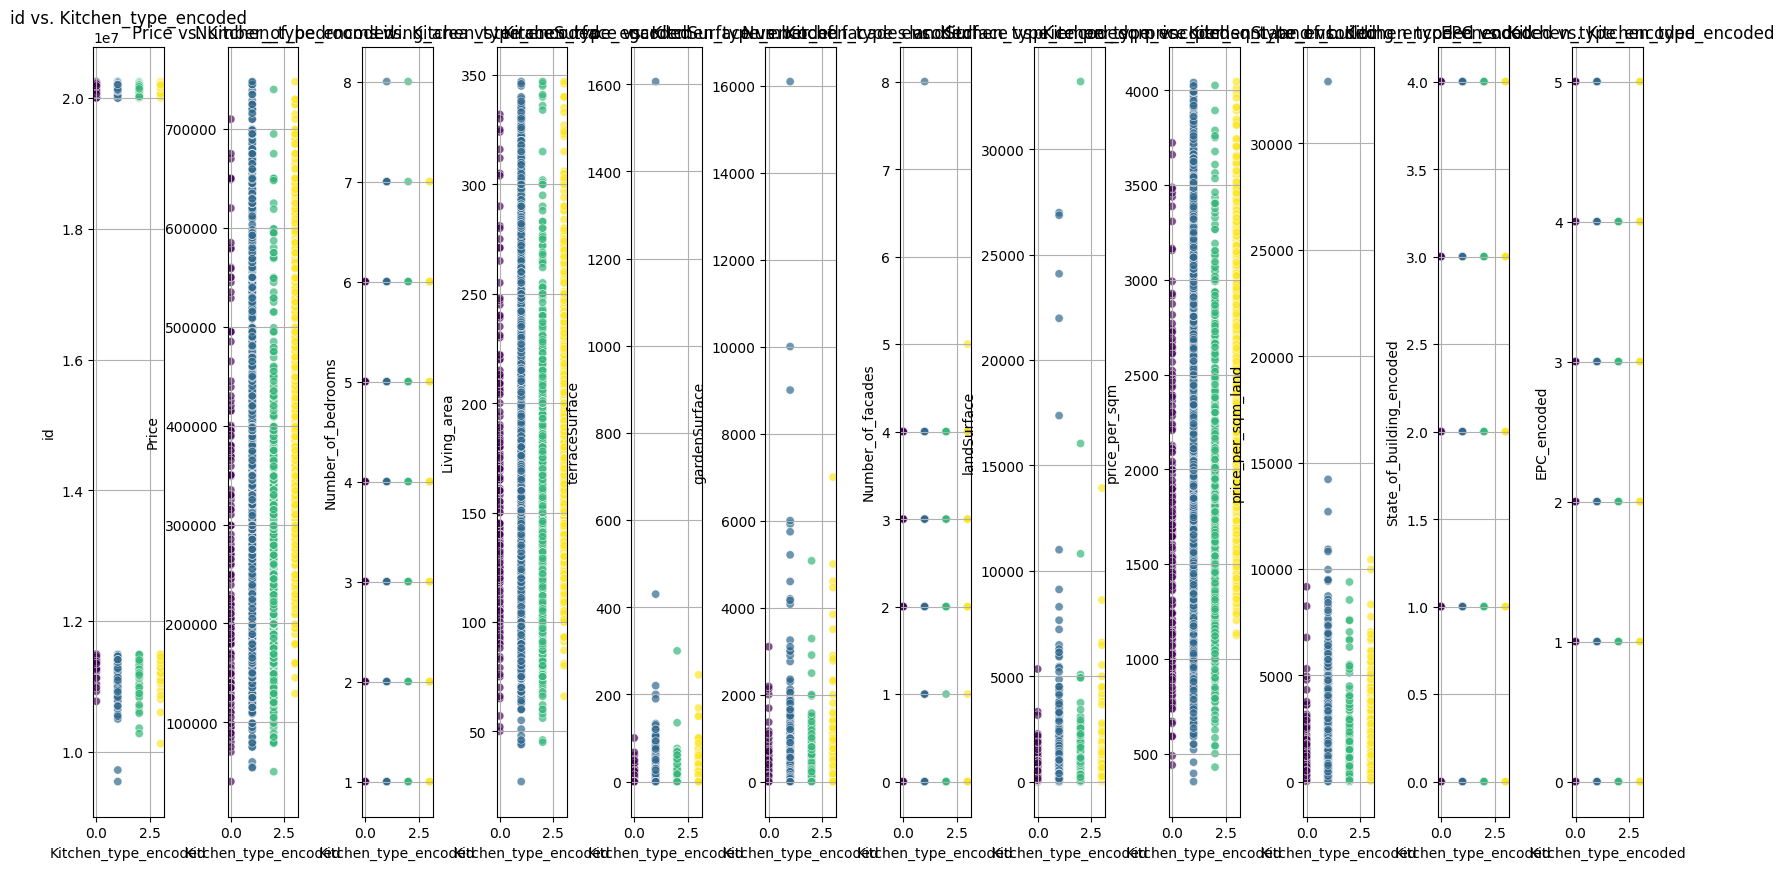

In [118]:
# encoded_columns = ['Kitchen_type_encoded']

# # List of numerical columns
# numerical_columns = df_1.select_dtypes(include=['Int64', 'float64']).columns.tolist()

# # Remove the encoded columns from the numerical list to avoid plotting against themselves
# numerical_columns = [col for col in numerical_columns if col not in encoded_columns]

# # Exclude latitude and longitude from the numerical columns
# numerical_columns = [col for col in numerical_columns if col not in ['latitude', 'longitude']]

# # Set up the plots
# num_encoded_columns = len(encoded_columns)
# num_numerical_columns = len(numerical_columns)

# # Create a grid of scatter plots
# plt.figure(figsize=(20, 10 * num_encoded_columns))

# for i, encoded_col in enumerate(encoded_columns):
#     for j, num_col in enumerate(numerical_columns):
#         plt.subplot(num_encoded_columns, num_numerical_columns, i * num_numerical_columns + j + 1)
#         scatter = sns.scatterplot(x=df_1[encoded_col], y=df_1[num_col], hue=df_1['Kitchen_type_encoded'], palette='viridis', alpha=0.7, legend = False)
#         plt.title(f'{num_col} vs. {encoded_col}')
#         plt.xlabel(encoded_col)
#         plt.ylabel(num_col)
#         plt.grid(True)


# plt.subplots_adjust(hspace=0.9, wspace=0.9)
# plt.show()

Pearson correlation coefficients:
                                 id     Price  Number_of_bedrooms  \
id                         1.000000  0.053072           -0.006077   
Price                      0.053072  1.000000            0.325052   
Number_of_bedrooms        -0.006077  0.325052            1.000000   
Living_area               -0.009715  0.535161            0.520726   
latitude                   0.079777  0.212106           -0.005209   
longitude                 -0.070096 -0.000980           -0.007401   
terraceSurface            -0.016129  0.061826            0.036924   
gardenSurface             -0.038276  0.107278            0.044841   
Number_of_facades         -0.058736  0.122005            0.034073   
landSurface               -0.010258  0.200399            0.052779   
price_per_sqm              0.067565  0.621168           -0.099773   
price_per_sqm_land         0.033506  0.104772           -0.004028   
Kitchen_type_encoded       0.029186  0.166243            0.000013   


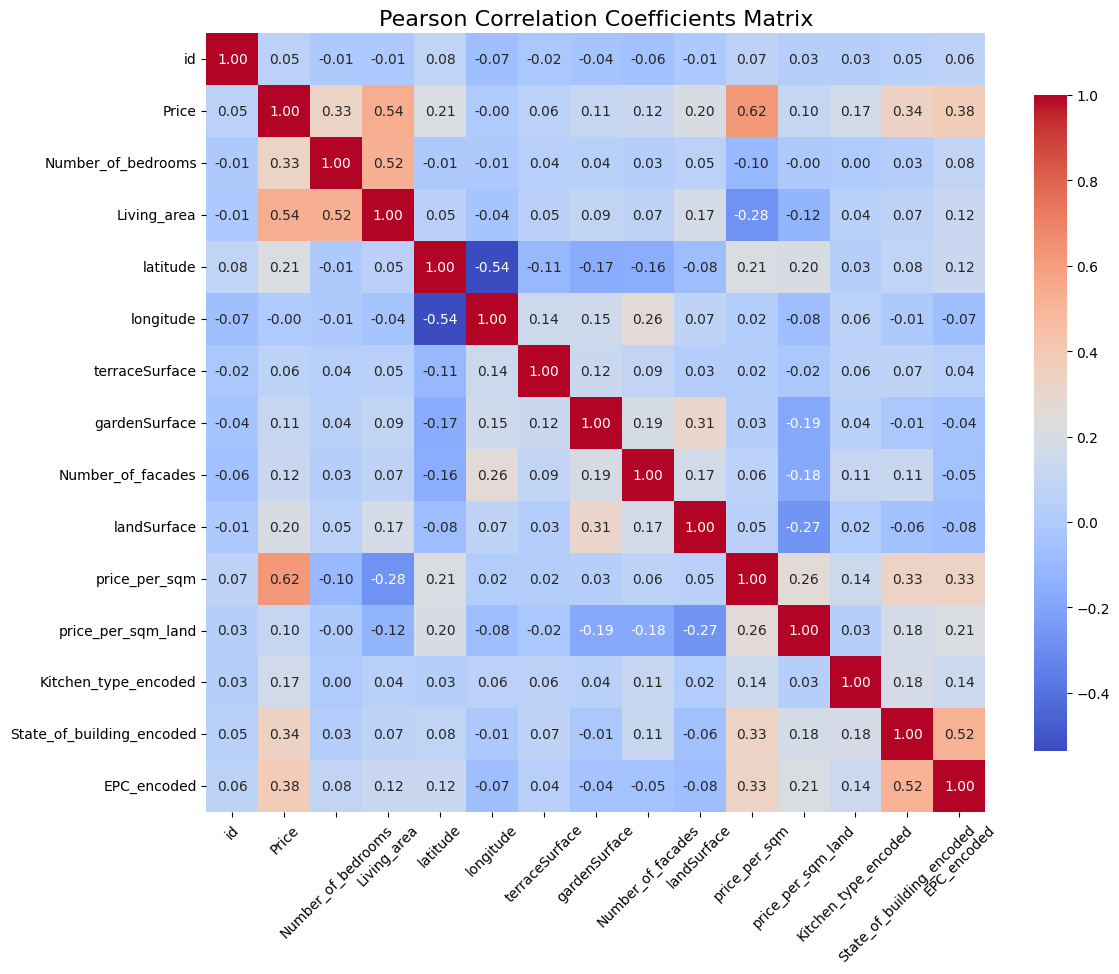

In [17]:

# Select numerical variables
numerical_columns = df_1.select_dtypes(include=['Int64', 'float64']).columns.tolist()

# Calculate Pearson correlation coefficient only for numerical variables
pearson_correlation = df_1[numerical_columns].corr(method='pearson')

# Display the Pearson correlation coefficients table
print("Pearson correlation coefficients:")
print(pearson_correlation)

# Set up the plot
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_correlation, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title
plt.title('Pearson Correlation Coefficients Matrix', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=0)   # Y-axis labels horizontal
plt.tight_layout()       # Automatically adjust layout
plt.show()


**Correlation scatter plot to use for 'just 2 datasets': lmplot**

c:\Users\tom_v\becode_projects\3_ImmoWeb_scraper\immo-eliza-team6-analysis\.venv\Lib\site-packages\numpy\_core\function_base.py:169: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\tom_v\becode_projects\3_ImmoWeb_scraper\immo-eliza-team6-analysis\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


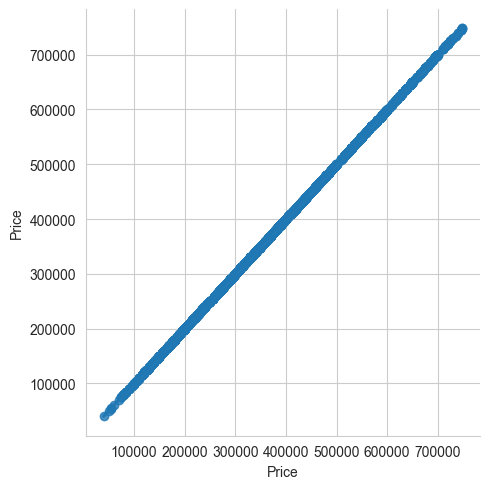

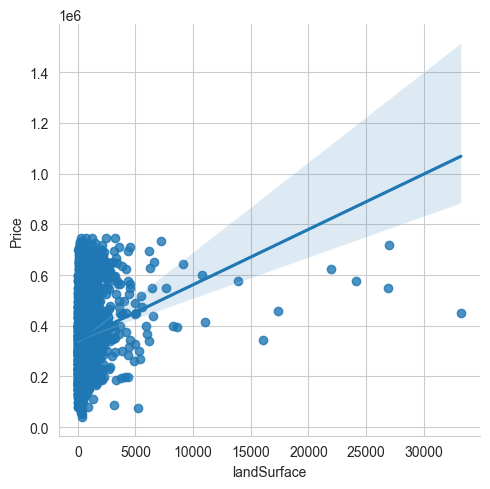

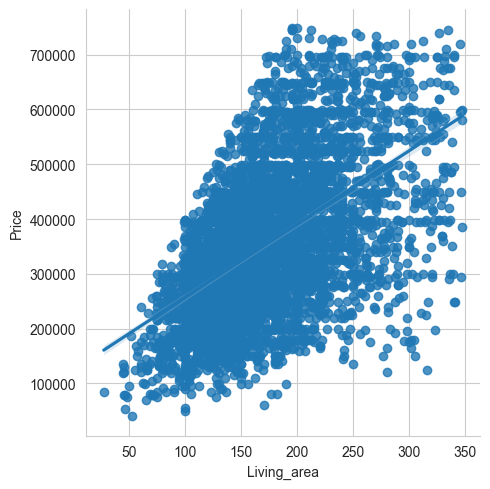

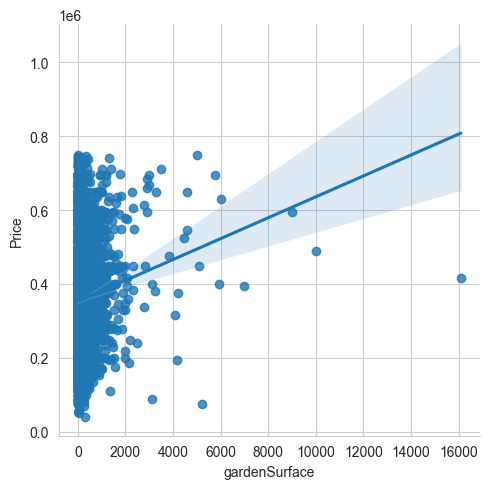

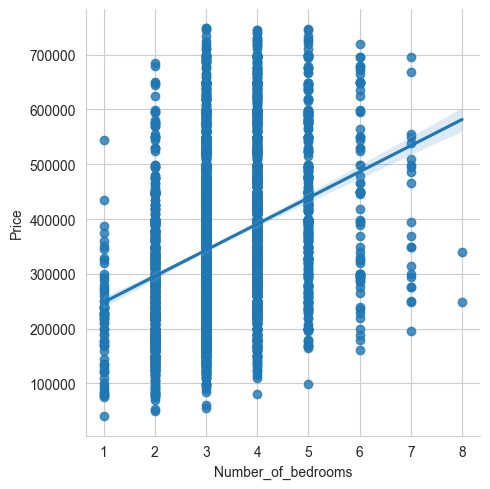

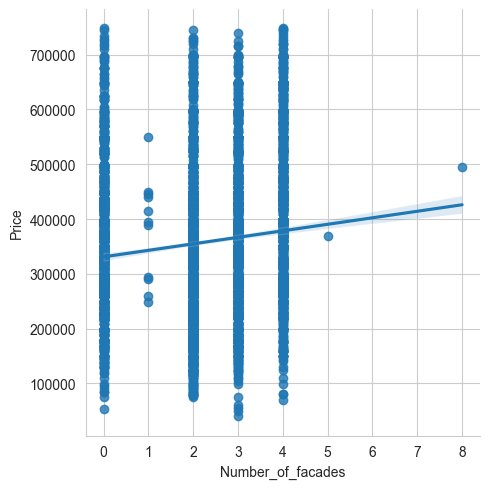

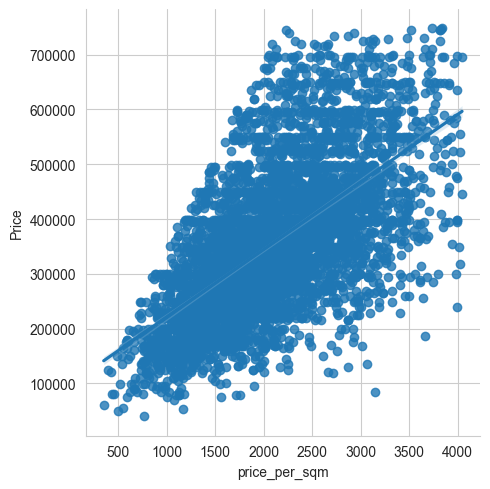

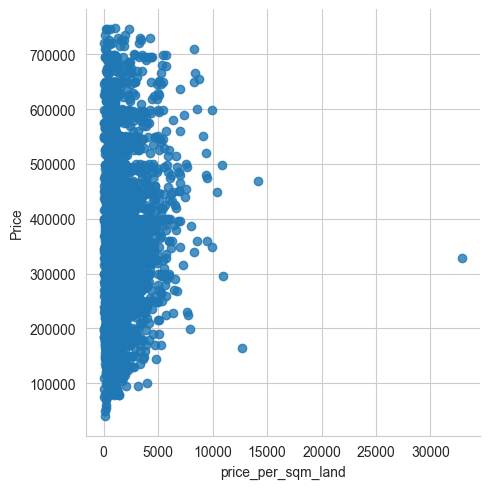

In [ ]:
cols_to_plot = ['Price','landSurface', 'Living_area','gardenSurface', 'Number_of_bedrooms', 'Number_of_facades','price_per_sqm',  'price_per_sqm_land']
for col in cols_to_plot:
    sns.lmplot(data=df_1, x=col, y="Price") #col="time", hue="smoker"


**Saving data to a new .csv file and a .pkl file**

In [119]:
# Save data to new csv file

output_csv = r'..\data\clean\after_step_4_correlation.csv'  # Fill your path to file
df_1.to_csv(output_csv, index=False)


# Save data to new pkl file

import pickle
output_pkl = r'..\data\clean\after_step_4_correlation.pkl' # Fill your path to file
with open(output_pkl, 'wb') as f:
    pickle.dump(df_1, f)
